In [1]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}


<IPython.core.display.Javascript object>

In [2]:
%matplotlib inline
import ipywidgets
from funciones import *
from ipywidgets import fixed
from functools import partial
from IPython.display import display

# backends: notebook, inline, ipympl...


In [3]:

puntos_rutina_num = [64,128,256,512]


puntos_num_bandas = np.arange(6,16,1)
#resultados_num_bandas = rutina(num_bandas=6,
#       archivo_control='control-num1.ctl',
#       control=[6,64,3], # num_bandas, resolucion, mesh;  e,a; e max 
#       puntos=puntos_num_bandas,
#       tipo=['num',0], # num, mat o lineal. indice para introduccion   
#       cifras=2, # solo se usa para el balance de proporciones
#       nombre='rutina-num-bandas',
#       funcion=default
#      )

puntos_resolucion = [2**(i+4) for i in range(10)]
#resultados_resolucion = rutina(num_bandas=6,
#       archivo_control='control-num1.ctl',
#      control=[6,64,3], # num_bandas, resolucion, mesh;  e,a; e max 
#       puntos=puntos_resolucion,
#       tipo=['num',1], # num, mat o lineal. indice para introduccion   
#       cifras=2, # solo se usa para el balance de proporciones
#       nombre='rutina-resolucion',
#       funcion=default
#      )

puntos_mesh = np.arange(5, 500, 50)
#resultados_mesh = rutina(num_bandas=6,
#       archivo_control='control-num1.ctl',
#       control=[6,64,3], # num_bandas, resolucion, mesh;  e,a; e max 
#       puntos=puntos_mesh,
#       tipo=['num',2], # num, mat o lineal. indice para introduccion   
#       cifras=2, # solo se usa para el balance de proporciones
#       nombre='rutina-mesh',
#       funcion=default
#      )

#anhadir interpolacion?

puntos_epsilon_a = np.round(np.arange(1.5,6.5,0.5),2)


In [4]:
nombre = 'epsilon-a'
with open('resultados-' + nombre + '.pkl', 'rb') as f:
    resultados = pickle.load(f)

nombre = 'epsilon-a-mesh'
with open('resultados-' + nombre + '.pkl', 'rb') as f:
    resultados_mesh = pickle.load(f)
    
print(np.max(resultados['tefreqs'][0] - resultados_mesh['tefreqs'][0]))


1.0000000000509601e-05


In [5]:
def traductor(param_red, resultados):
    c = 3.0e8
    factor = c/param_red

    for i in range(len(resultados['tefreqs'])):
        resultados['tefreqs'][i] = factor*resultados['tefreqs'][i]
    
    resultados['gaps']['Ancho TE'] = factor*resultados['gaps']['Ancho TE']
    resultados['gaps']['Prom TE'] = factor*resultados['gaps']['Prom TE']

    return resultados


def graficador(resultados,
               puntos=0,
               num_bandas=6,
               pola='te',
               ejex='Puntos de la rutina (u.i)',
               ejey=lambda num_gap: 'Gap ' + str(num_gap) + ' (c/a)',
               titulo=lambda num_gap: 'del gap ' + str(num_gap) + ' en función de los puntos de la rutina',
               param_red=0.0,
               rango=0.0,
              ):
    
    if (pola=='te'):
        llaves = ['tefreqs', 'tevels',  'Ancho TE', 'Promedio TE', 'Porcentaje TE']
    elif (pola=='tm'):
        llaves = ['tmfreqs', 'tmvels',  'Ancho TM', 'Promedio TM', 'Porcentaje TM']
    
    try:
        with open('resultados-' + resultados + '.pkl', 'rb') as f:
            resultados = pickle.load(f)
    except:
        try:
            with open(resultados + '/resultados-' + resultados + '.pkl', 'rb') as f:
                resultados = pickle.load(f)
        except:
            pass
    
    if isinstance(puntos, int): puntos = resultados['puntos']
    
    #try:
    #    if (puntos==0): puntos = resultados['puntos']
    #    else: print('puntos de rutina no valido')
    #except:
    #    pass
    
    if (param_red != 0.0):
        resultados = traductor(param_red, resultados)
    
    def func_indice(valor): 
        try:
            indice = int(np.where(puntos == valor)[0][0])
        except:
            indice = puntos.index(valor)
        return indice
    
    def graf_bandas(valor, num_bandas, track=num_bandas-1):
        indice = func_indice(valor)
        fig, ax = plt.subplots()
        for i in range(track+1):
            k_vector = np.linspace(-0.5, 0.5, int(len(resultados[llaves[0]][indice][i])))
            ax.scatter(k_vector, resultados[llaves[0]][indice][i], c='r', s=0.1)
        
        parametros = resultados['parametros'][indice]
        identidad = str(parametros[0])
        for i in range(len(parametros)-1):
            identidad = identidad + '-' + str(parametros[i+1])

        ax.set_xlabel('Vector de onda (ka/2pi)')
        ax.set_ylabel('Frecuencia (wa/2pic)')
        ax.set_title(str(track+1) + " bandas " + pola.upper() + " con " + identidad)
        
        if (rango != 0.0):
            ax.set_ylim(rango)
        
    def graf_vels(valor, num_bandas, track=num_bandas-1):
        indice = func_indice(valor)
        fig, ax = plt.subplots()
        for i in range(track+1):
            k_vector = np.linspace(-0.5, 0.5, int(len(resultados[llaves[1]][indice][i])))
            ax.scatter(k_vector, resultados[llaves[1]][indice][i], c='r', s=0.1)
        
        parametros = resultados['parametros'][indice]
        identidad = str(parametros[0])
        for i in range(len(parametros)-1):
            identidad = identidad + '-' + str(parametros[i+1])

        ax.set_xlabel('Vector de onda (ka/2pi)')
        ax.set_ylabel('Frecuencia (wa/2pic)')
        ax.set_title(str(track+1) + " bandas " + pola.upper() + " con " + identidad)
        
        if (rango != 0.0):
            ax.set_ylim(rango)
        
    def graf_rutina(num_gap=1,tipo=llaves[2]):
        fig, ax = plt.subplots()
        fig.subplots_adjust(0.2,0.2)
        plt.ticklabel_format(style='plain', useOffset=False)
        ax.scatter(puntos, resultados['gaps'][tipo][num_gap-1], c='r')
        ax.set_xlabel('Puntos de la rutina (u.i)')
        ax.set_ylabel((ejey)(num_gap))
        if (tipo==llaves[2]):
            ax.set_title("Ancho " + (titulo)(num_gap))
            if (param_red != 0.0):
                ax.ticklabel_format(style='sci',scilimits=(0,0),axis='y')
        elif (tipo==llaves[3]):
            ax.set_title("Promedio " + (titulo)(num_gap))
            if (param_red != 0.0):
                ax.ticklabel_format(style='sci',scilimits=(0,0),axis='y')
        else:
            ax.set_title("Porcentaje " + (titulo)(num_gap))
        
    
    ipywidgets.interact(graf_bandas,
                        valor=ipywidgets.SelectionSlider(description='e1',
                                                         options=puntos
                                                        ),
                        num_bandas=fixed(num_bandas),
                        track=fixed(num_bandas-1)
                       )
    
    ipywidgets.interact(graf_rutina,
                        num_gap=ipywidgets.SelectionSlider(description='Gap',
                                                         options=np.arange(1,num_bandas,1)
                                                        ),
                        tipo=ipywidgets.Dropdown(options=[llaves[2], llaves[3], llaves[4]],
                                             value=llaves[2],
                                             description='Serie:',
                                             disabled=False,
                                            )
                       )


In [6]:
graficador('epsilon-a',
           #puntos=puntos_epsilon_a,
           #num_bandas=6,
           #pola='te'#,
           #ejex='Puntos de la rutina (u.i)',
           #ejey=lambda num_gap: 'Gap ' + str(num_gap) + ' (c/a)',
           #titulo=lambda num_gap: 'del gap ' + str(num_gap) + ' en función de los puntos de la rutina',
           #param_red=0.63e-6,
           #rango=[0.0,1.0e15]
          )

interactive(children=(SelectionSlider(description='e1', options=(1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0, 5.5, …

interactive(children=(SelectionSlider(description='Gap', options=(1, 2, 3, 4, 5), value=1), Dropdown(descripti…

interactive(children=(SelectionSlider(description='e1', options=('r', 'u', 't', 'i', 'n', 'a', '-', 'n', 'u', …

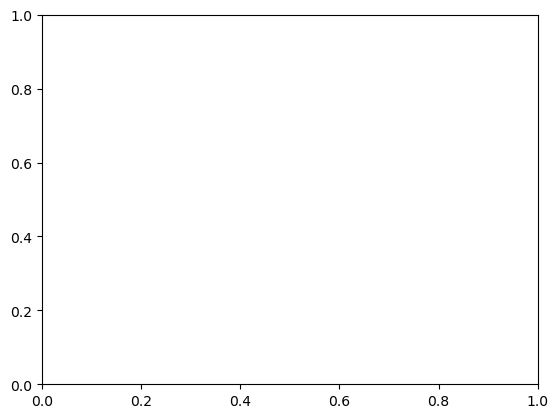

interactive(children=(SelectionSlider(description='Gap', options=(1, 2, 3, 4, 5), value=1), Dropdown(descripti…

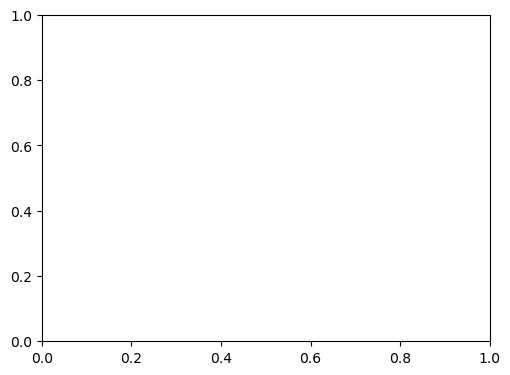

In [7]:
graficador(puntos_rutina_num,
           'rutina-num'#,
           #ejex='Puntos de la rutina (u.i)',
           #ejey=lambda num_gap: 'Gap ' + str(num_gap) + ' (c/a)',
           #titulo=lambda num_gap: 'del gap ' + str(num_gap) + ' en función de los puntos de la rutina',
           #param_red=0.63e-6,
           #rango=[0.0,1.0e15]
          )

interactive(children=(SelectionSlider(description='e1', options=('r', 'u', 't', 'i', 'n', 'a', '-', 'n', 'u', …

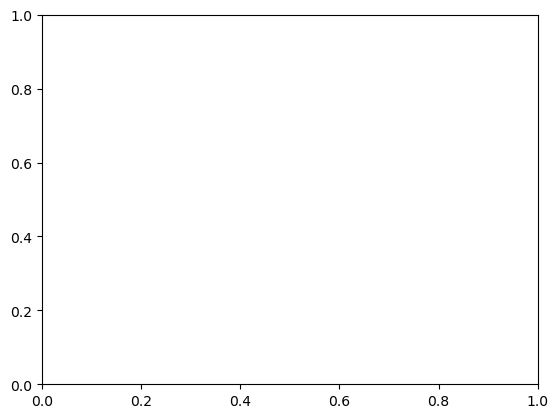

interactive(children=(SelectionSlider(description='Gap', options=(1, 2, 3, 4, 5), value=1), Dropdown(descripti…

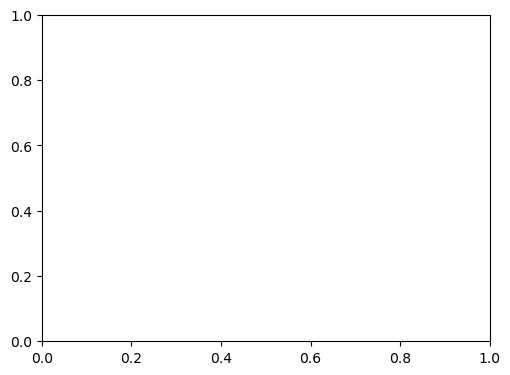

In [8]:
graficador(puntos_num_bandas,
           'rutina-num-bandas'#,
           #ejex='Puntos de la rutina (u.i)',
           #ejey=lambda num_gap: 'Gap ' + str(num_gap) + ' (c/a)',
           #titulo=lambda num_gap: 'del gap ' + str(num_gap) + ' en función de los puntos de la rutina',
           #param_red=0.63e-6,
           #rango=[0.0,1.0e15]
          )

interactive(children=(SelectionSlider(description='e1', options=('r', 'u', 't', 'i', 'n', 'a', '-', 'r', 'e', …

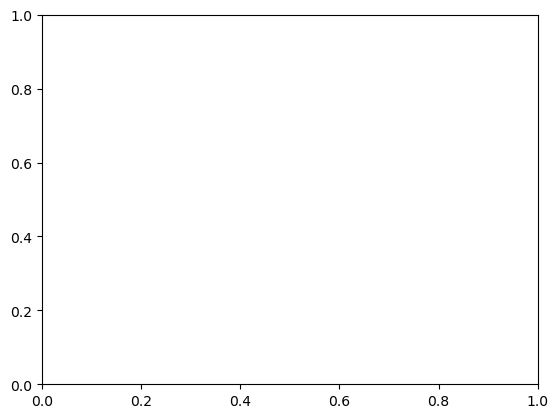

interactive(children=(SelectionSlider(description='Gap', options=(1, 2, 3, 4, 5), value=1), Dropdown(descripti…

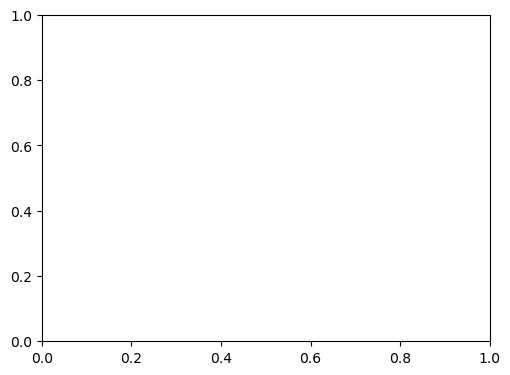

In [9]:
graficador(puntos_resolucion,
           'rutina-resolucion'#,
           #ejex='Puntos de la rutina (u.i)',
           #ejey=lambda num_gap: 'Gap ' + str(num_gap) + ' (c/a)',
           #titulo=lambda num_gap: 'del gap ' + str(num_gap) + ' en función de los puntos de la rutina',
           #param_red=0.63e-6,
           #rango=[0.0,1.0e15]
          )

interactive(children=(SelectionSlider(description='e1', options=('r', 'u', 't', 'i', 'n', 'a', '-', 'm', 'e', …

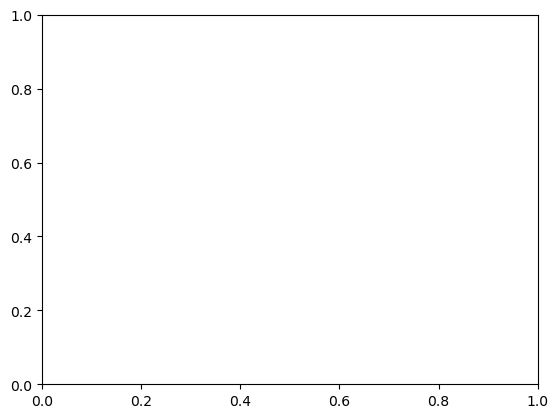

interactive(children=(SelectionSlider(description='Gap', options=(1, 2, 3, 4, 5), value=1), Dropdown(descripti…

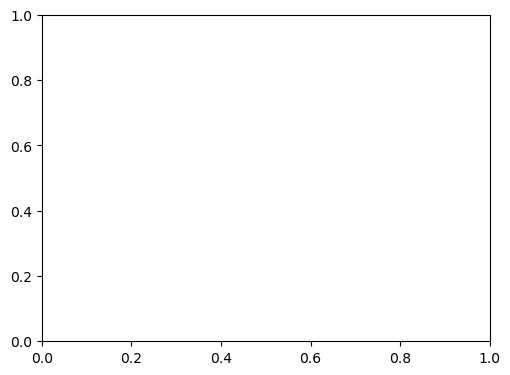

In [10]:
graficador(puntos_mesh,
           'rutina-mesh'#,
           #ejex='Puntos de la rutina (u.i)',
           #ejey=lambda num_gap: 'Gap ' + str(num_gap) + ' (c/a)',
           #titulo=lambda num_gap: 'del gap ' + str(num_gap) + ' en función de los puntos de la rutina',
           #param_red=0.63e-6,
           #rango=[0.0,1.0e15]
          )